In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.inference.model_inversion import MIFace

# 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義簡單的神經網絡
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 設定數據集與轉換
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# 加載數據集
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 初始化模型
model = SimpleCNN().to(device)

# 設定損失函數與優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [2]:
# 訓練模型
model.train()
for epoch in range(3):  # 訓練3個epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 使用 ART 的 PyTorchClassifier 將模型封裝
classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)


Model inversion:   0%|          | 0/1 [00:00<?, ?it/s]

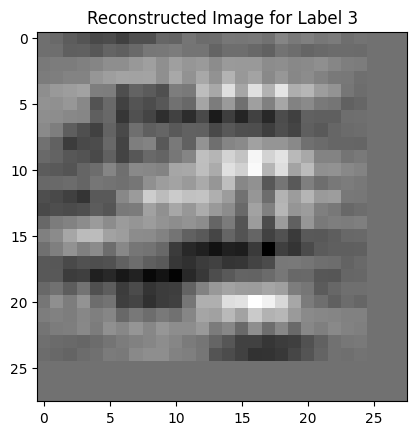

In [3]:
import numpy as np

# 初始化模型侵害攻擊 (Model Inversion Attack)
mia_attack = MIFace(classifier, max_iter=100)

import numpy as np

# 生成模型侵害圖片 (進行反向推理以恢復訓練數據的輸入)
# 假設目標類別為 '3'
# Convert the list to a NumPy array
y_target = np.array([3])  # Assuming '3' is the class you want to reverse

# Perform the attack with the corrected label format
reconstructed_image = mia_attack.infer(x=None, y=y_target)

# 可視化恢復出的圖片
import matplotlib.pyplot as plt
plt.imshow(reconstructed_image[0].reshape(28, 28), cmap="gray")
plt.title("Reconstructed Image for Label 3")
plt.show()